In [2]:
import os, shutil, torch
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    Orientationd,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Spacingd,
    MapTransform,
    ToTensord,
    ConcatItemsd,
    RandSpatialCropd,
    CenterSpatialCropd,
)
from monai.data import Dataset, DataLoader
import nibabel as nib
import numpy as np 
from monai import transforms, data
import matplotlib.pyplot as plt 

class ConvertLabelBasedOnClasses(MapTransform):
    def __call__(self, data):
        d = dict(data)
        # print(data)
        for key in self.keys:
            result = d[key] > 1
            d[key] = result.float()
        return d

class DeleteDataKeysd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            del d[key]
        return d
    
def find_bbox(seg):
    x_start, x_end = np.where(np.any(seg, axis=(1, 2)))[0][[0, -1]]
    y_start, y_end = np.where(np.any(seg, axis=(0, 2)))[0][[0, -1]]
    z_start, z_end = np.where(np.any(seg, axis=(0, 1)))[0][[0, -1]]

    return (x_start, x_end, y_start, y_end, z_start, z_end)

PAIs249 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -2.2478094 4.7398825


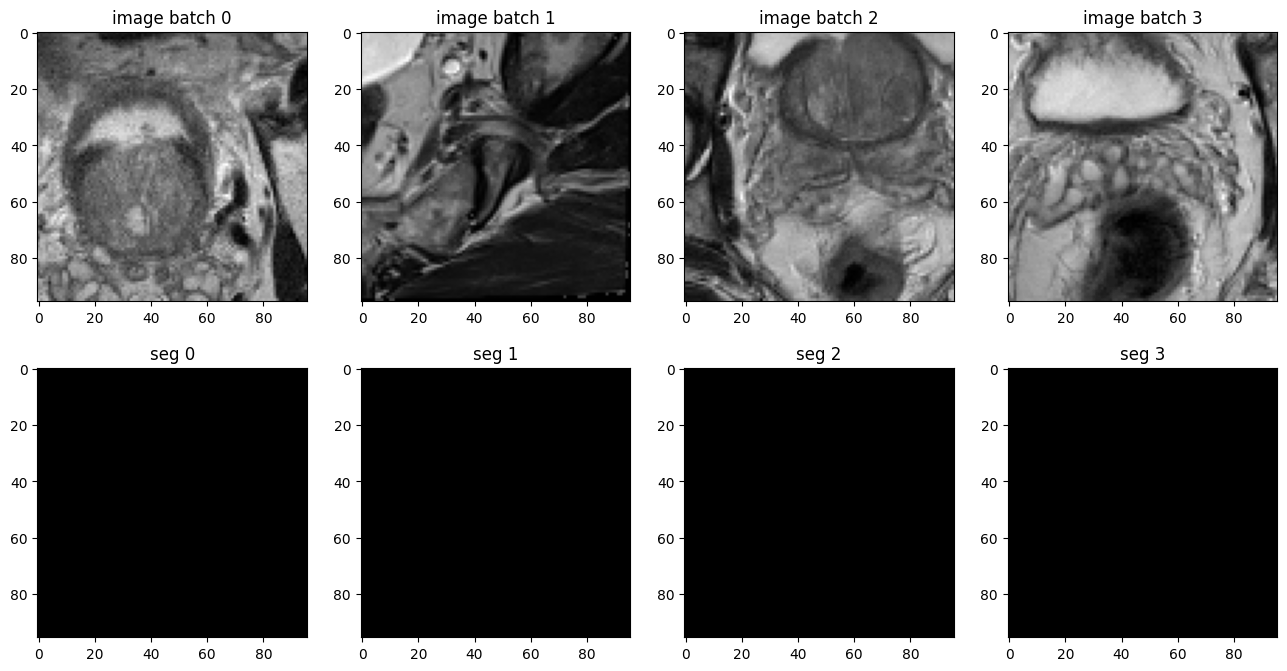

PAIs088 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -1.4296992 4.567183


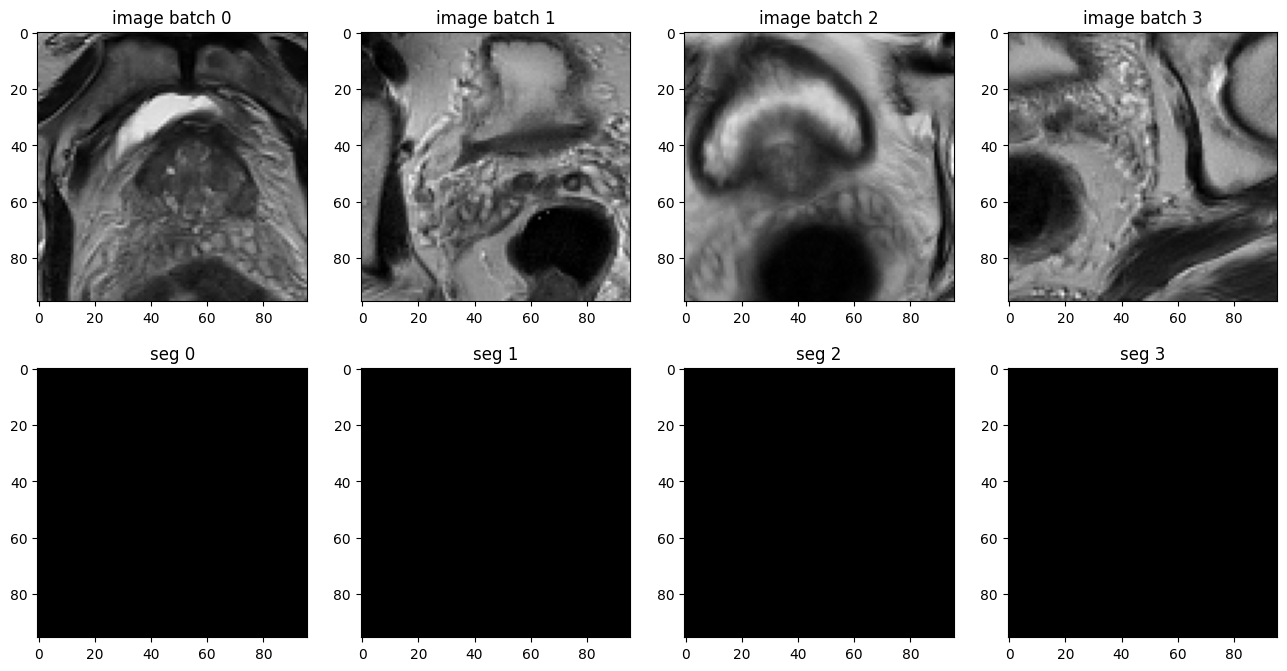

PAIs278 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -1.4834822 4.013456


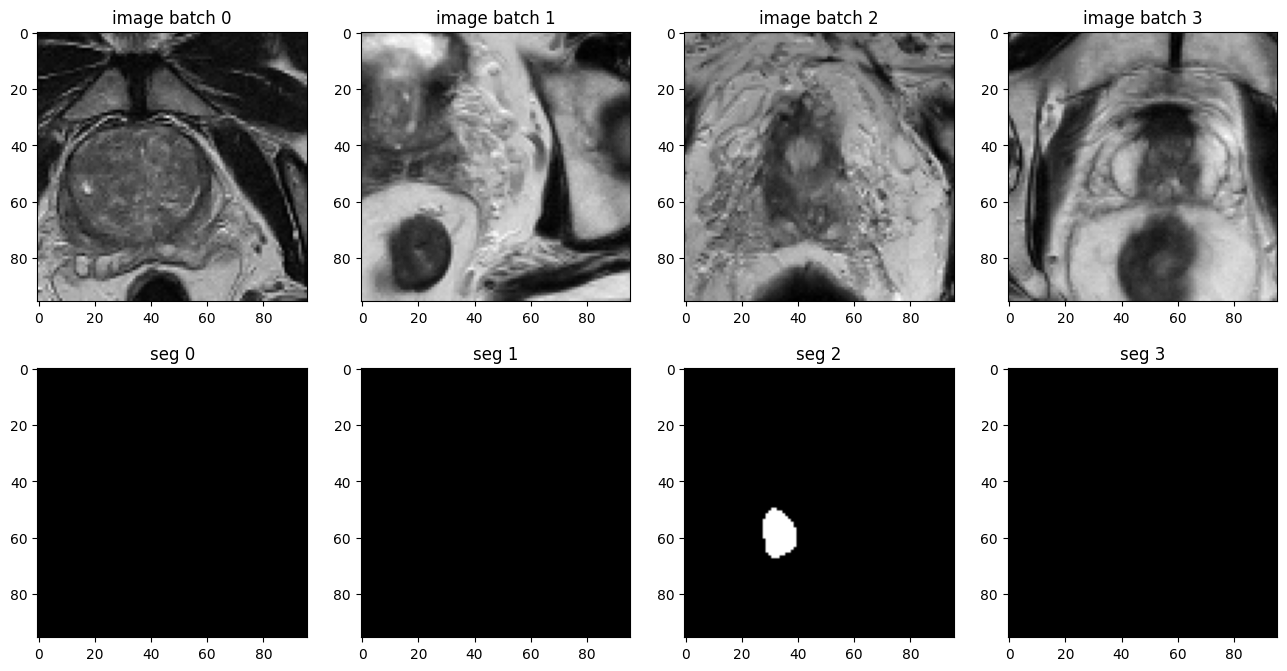

PAIs086 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -1.7482098 3.652574


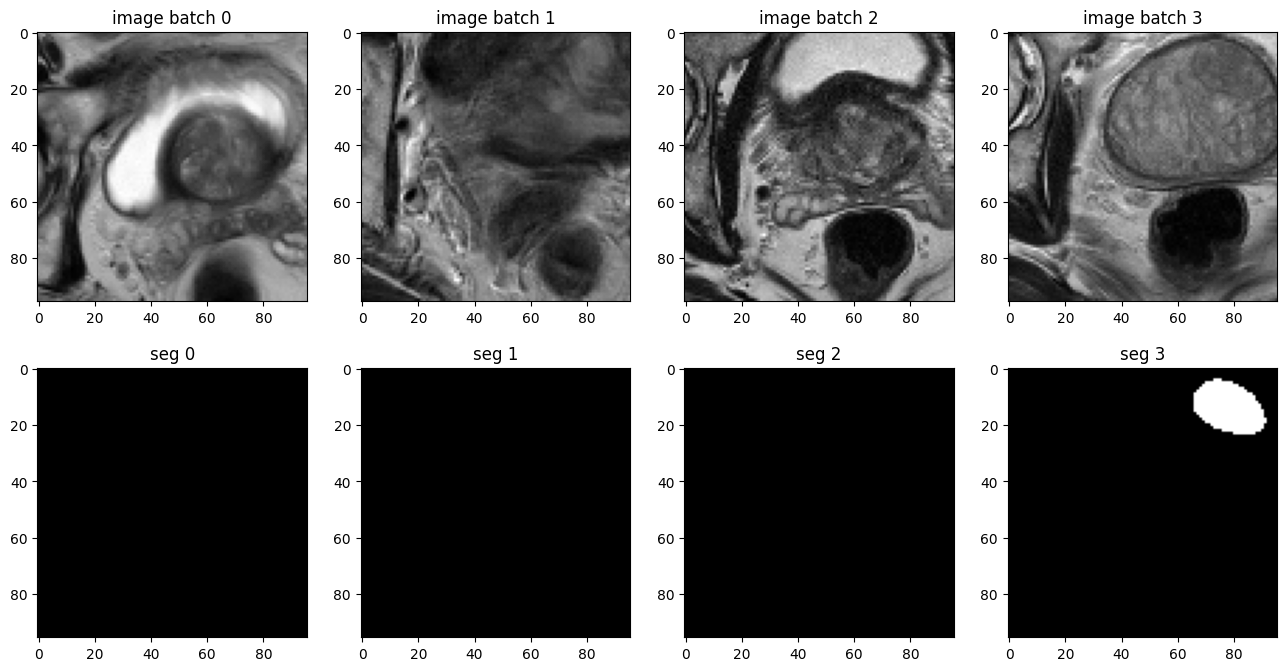

PAIs021 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -1.5733278 3.2273717


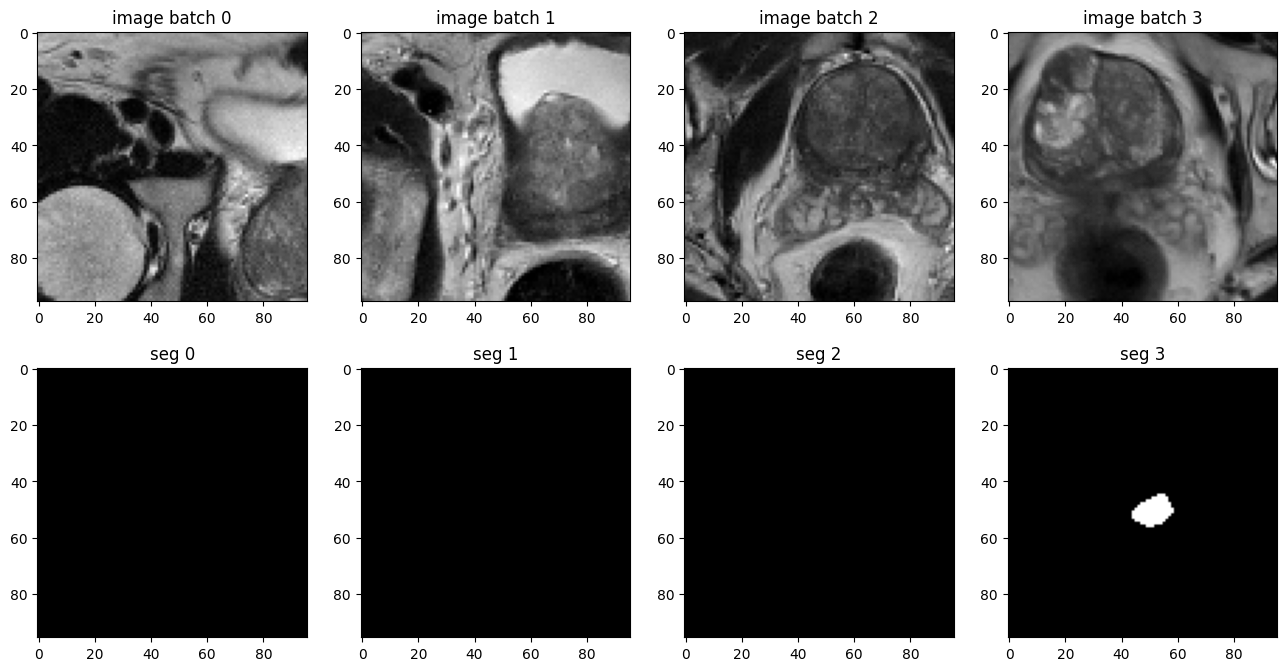

In [14]:
x, y, z = 96, 96, 32
B = 4
modality = 'T2W'
tiantian_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/tiantian"
name_list = os.listdir(tiantian_root)
datalist = []
for name in name_list:
    sample = {"label": os.path.join(tiantian_root, name, f'{name}_{modality}_gt.nii.gz')}
    # for modality in ['T2W', 'DWI', 'ADC']:
    #     sample[modality] = os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')
    sample["image"] = os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')
    datalist.append(sample)

train_transform = Compose(
    [
        ## load 4 Nifti images and stack them together
        # LoadImaged(keys=["T2W", "DWI", "ADC", "label"]),
        # EnsureTyped(keys=["T2W", "DWI", "ADC", "label"]),
        # ConvertLabelBasedOnClasses(keys="label"),
        # EnsureChannelFirstd(keys=["T2W", "DWI", "ADC", "label"]),
        # ConcatItemsd(keys=["T2W", "DWI", "ADC"], name="image"),
        
        # load single modality
        LoadImaged(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        ConvertLabelBasedOnClasses(keys="label"),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        # RandSpatialCropd(keys=["image", "label"], roi_size=[x, y, z], random_size=False),

        # transforms.SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[x, y, z]),
        transforms.RandCropByLabelClassesd(
                keys=["image", "label"],
                label_key="label",
                spatial_size=[x, y, z],
                num_classes=2,
                ratios=[1,3],
                num_samples=1,
            ),
        # RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=0),
        # RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=1),
        # RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        # RandScaleIntensityd(keys="image", factors=0.1, prob=0.1),
        # RandShiftIntensityd(keys="image", offsets=0.1, prob=0.1),
        ToTensord(keys=["image", "label"]),
        # DeleteDataKeysd(keys=["T2W", "DWI", "ADC"]),
    ]
)
train_ds = Dataset(data=datalist, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=B, shuffle=False, num_workers=0)

for idx, check_data in enumerate(train_loader):
    name = check_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
    img   = check_data['image']
    label = check_data['label']
    print(name, img.shape, label.shape, np.max(label), np.min(img[0]), np.max(img[0]))
    # break
    plt.figure(figsize=(4*B, 8))
    for i in range(B):
        plt.subplot(2, B, i+1)
        plt.title(f"image batch {i}")
        plt.imshow(img[i,0,...,31].detach().cpu(), cmap="gray")

        plt.subplot(2, B, i+1+B)
        plt.title(f"seg {i}")
        plt.imshow(label[i][0,...,31].detach().cpu(), cmap="gray")
    plt.show()
    if idx == 4:
        break

In [ ]:
x, y, z = 96, 96, 32
B = 4
modality = 'T2W'
tiantian_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/tiantian"
name_list = os.listdir(tiantian_root)
datalist = []
for name in name_list:
    sample = {"label": os.path.join(tiantian_root, name, f'{name}_{modality}_gt.nii.gz')}
    sample["image"] = os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')

    for modality in ['T2W', 'DWI', 'ADC']:
        sample[modality] = os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')
    datalist.append(sample)

train_transform = Compose(
    [
        ## load 4 Nifti images and stack them together
        # LoadImaged(keys=["T2W", "DWI", "ADC", "label"]),
        # EnsureTyped(keys=["T2W", "DWI", "ADC", "label"]),
        # ConvertLabelBasedOnClasses(keys="label"),
        # EnsureChannelFirstd(keys=["T2W", "DWI", "ADC", "label"]),
        # ConcatItemsd(keys=["T2W", "DWI", "ADC"], name="image"),
        
        # load single modality
        LoadImaged(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        ConvertLabelBasedOnClasses(keys="label"),
        EnsureChannelFirstd(keys=["image", "label"]),

        # Orientationd(keys=["image", "label"], axcodes="RAS"),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        transforms.SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[x, y, z]),
        transforms.RandCropByLabelClassesd(
                keys=["image", "label"],
                label_key="label",
                spatial_size=[x, y, z],
                num_classes=2,
                ratios=[0,1],
                num_samples=1,
            ),
        # RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=0),
        # RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=1),
        # RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        # RandScaleIntensityd(keys="image", factors=0.1, prob=0.1),
        # RandShiftIntensityd(keys="image", offsets=0.1, prob=0.1),
        ToTensord(keys=["image", "label"]),
        # DeleteDataKeysd(keys=["T2W", "DWI", "ADC"]),
    ]
)
train_ds = Dataset(data=datalist, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=B, shuffle=False, num_workers=0)

for idx, check_data in enumerate(train_loader):
    name = check_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
    img   = check_data['image']
    label = check_data['label']
    print(name, img.shape, label.shape, np.max(label), np.min(img[0]), np.max(img[0]))
    # break
    plt.figure(figsize=(4*B, 8))
    for i in range(B):
        plt.subplot(2, B, i+1)
        plt.title(f"image batch {i}")
        plt.imshow(img[i,0,...,16].detach().cpu(), cmap="gray")

        plt.subplot(2, B, i+1+B)
        plt.title(f"seg {i}")
        plt.imshow(label[i,0,...,16].detach().cpu(), cmap="gray")
    plt.show()
    if idx == 1:
        break

In [52]:
x, y, z = 96, 96, 32
B = 1
modality = 'T2W'
tiantian_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/tiantian"
name_list = os.listdir(tiantian_root)
datalist = []
for name in name_list:
    sample = {"label": os.path.join(tiantian_root, name, f'{name}_{modality}_gt.nii.gz')}
    # for modality in ['T2W', 'DWI', 'ADC']:
    #     sample[modality] = os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')
    sample["image"] = os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')
    datalist.append(sample)

train_transform = Compose(
    [
        ## load 4 Nifti images and stack them together
        # LoadImaged(keys=["T2W", "DWI", "ADC", "label"]),
        # EnsureTyped(keys=["T2W", "DWI", "ADC", "label"]),
        # ConvertLabelBasedOnClasses(keys="label"),
        # EnsureChannelFirstd(keys=["T2W", "DWI", "ADC", "label"]),
        # ConcatItemsd(keys=["T2W", "DWI", "ADC"], name="image"),
        
        # load single modality
        LoadImaged(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        # ConvertLabelBasedOnClasses(keys="label"),
        EnsureChannelFirstd(keys=["image", "label"]),

        # Orientationd(keys=["image", "label"], axcodes="RAS"),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 3.0),
            mode=("bilinear", "nearest"),
        ),
        # transforms.SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[x, y, z]),
        # transforms.RandCropByLabelClassesd(
        #         keys=["image", "label"],
        #         label_key="label",
        #         spatial_size=[x, y, z],
        #         num_classes=2,
        #         ratios=[0,1],
        #         num_samples=1,
        #     ),
        # RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=0),
        # RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=1),
        # RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=2),
        # NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        # RandScaleIntensityd(keys="image", factors=0.1, prob=0.1),
        # RandShiftIntensityd(keys="image", offsets=0.1, prob=0.1),
        # ToTensord(keys=["image", "label"]),
        # DeleteDataKeysd(keys=["T2W", "DWI", "ADC"]),
    ]
)
train_ds = Dataset(data=datalist, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=B, shuffle=False, num_workers=0)
zmin = 100
zmax = 0
for idx, check_data in enumerate(train_loader):
    name = check_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
    img   = check_data['image'][0][0]
    label = check_data['label'][0][0]
    x_start, x_end, y_start, y_end, z_start, z_end = find_bbox(label)
    z_length = z_end-z_start
    print(name, img.shape, label.shape, np.max(label), np.min(img), np.max(img))
    print(x_start, x_end, y_start, y_end, z_start, z_end, '\t', x_end-x_start, y_end-y_start, z_length)
    crop_img = img[x_start:x_end, y_start:y_end, z_start:z_end]

    # break
    # plt.figure(figsize=(8, 3))
    # plt.subplot(1, 3, 1)
    # plt.title(f"image")
    # plt.imshow(img[...,41].detach().cpu(), cmap="gray")

    # plt.subplot(1, 3, 2)
    # plt.title(f"seg")
    # plt.imshow(label[...,41].detach().cpu(), cmap="gray")

    # plt.subplot(1, 3, 3)
    # plt.title(f"crop img")
    # plt.imshow(crop_img[...,35].detach().cpu(), cmap="gray")
    # plt.show()
    # if idx == 1:
    #     break

    if z_length > zmax:
        zmax = z_length
    if z_length < zmin:
        zmin = z_length

print(zmin, zmax)

PAIs249 torch.Size([141, 141, 28]) torch.Size([141, 141, 28]) 3.0 7.0584326 2867.9163
46 99 38 100 3 26 	 53 62 23
PAIs044 torch.Size([200, 200, 35]) torch.Size([200, 200, 35]) 3.0 0.0 1699.7997
69 122 71 127 9 29 	 53 56 20
PAIs276 torch.Size([181, 181, 26]) torch.Size([181, 181, 26]) 2.0 0.0 5556.384
50 109 60 120 4 22 	 59 60 18
PAIs282 torch.Size([181, 181, 22]) torch.Size([181, 181, 22]) 2.0 0.0 5619.1655
73 113 58 113 2 17 	 40 55 15
PAIs088 torch.Size([201, 201, 29]) torch.Size([201, 201, 29]) 2.0 0.0 1308.7994
75 117 78 132 9 23 	 42 54 14
PAIs285 torch.Size([181, 181, 24]) torch.Size([181, 181, 24]) 2.0 0.0 6471.7783
67 111 66 113 4 20 	 44 47 16
PAIs271 torch.Size([166, 166, 25]) torch.Size([166, 166, 25]) 2.0 0.0 2450.064
71 103 62 111 6 19 	 32 49 13
PAIs043 torch.Size([181, 181, 27]) torch.Size([181, 181, 27]) 2.0 0.0 4741.0737
72 101 65 111 6 20 	 29 46 14
PAIs278 torch.Size([141, 141, 26]) torch.Size([141, 141, 26]) 2.0 0.0 3185.1885
47 97 41 99 1 21 	 50 58 20
PAIs075 t

In [8]:
name_list = []
with open('./train_case_level.txt', 'r') as f:
    lines = f.readlines()
    for name in lines:
        name = name.strip()
        name_list.append(name)

tiantian_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/tiantian"
adc_list = []
dwi_list = []
t2w_list = []
for name in name_list:
    dwi_gt = nib.load(os.path.join(tiantian_root, name, name+"_DWI_gt.nii.gz")).get_fdata()
    adc_gt = nib.load(os.path.join(tiantian_root, name, name+"_ADC_gt.nii.gz")).get_fdata()
    t2w_gt = nib.load(os.path.join(tiantian_root, name, name+"_T2W_gt.nii.gz")).get_fdata()

    if np.max(dwi_gt) > 1:
        dwi_list.append(name)
    if np.max(adc_gt) > 1:
        adc_list.append(name)
    if np.max(t2w_gt) > 1:
        t2w_list.append(name)

    print(name, np.max(dwi_gt), np.max(adc_gt), np.max(t2w_gt))


def write_list(name_list, save_name):
    with open(save_name, 'w') as f:
        for name in name_list:
            f.write(name)
            f.write('\n')


write_list(adc_list, './ADC.txt')
write_list(dwi_list, './DWI.txt')
write_list(t2w_list, './T2W.txt')




PAIs001 2.0 2.0 2.0
PAIs004 2.0 2.0 2.0
PAIs005 2.0 2.0 3.0
PAIs006 2.0 2.0 2.0
PAIs007 2.0 2.0 2.0
PAIs009 2.0 2.0 2.0
PAIs011 2.0 2.0 2.0
PAIs012 2.0 2.0 2.0
PAIs013 2.0 2.0 2.0
PAIs015 2.0 2.0 2.0
PAIs016 2.0 2.0 2.0
PAIs017 2.0 2.0 2.0
PAIs018 3.0 3.0 3.0
PAIs019 3.0 3.0 3.0
PAIs020 3.0 3.0 3.0
PAIs021 3.0 3.0 3.0
PAIs023 2.0 2.0 2.0
PAIs024 2.0 2.0 2.0
PAIs025 2.0 2.0 2.0
PAIs026 4.0 4.0 4.0
PAIs028 2.0 2.0 2.0
PAIs029 2.0 2.0 2.0
PAIs030 2.0 2.0 2.0
PAIs031 2.0 2.0 2.0
PAIs032 3.0 3.0 3.0
PAIs033 2.0 2.0 2.0
PAIs035 2.0 2.0 2.0
PAIs036 2.0 2.0 2.0
PAIs037 3.0 3.0 3.0
PAIs038 3.0 3.0 3.0
PAIs039 3.0 3.0 3.0
PAIs040 2.0 2.0 2.0
PAIs042 3.0 3.0 3.0
PAIs043 2.0 2.0 2.0
PAIs044 3.0 3.0 3.0
PAIs045 0.0 0.0 2.0
PAIs046 3.0 3.0 3.0
PAIs047 2.0 2.0 2.0
PAIs048 2.0 2.0 2.0
PAIs050 2.0 2.0 2.0
PAIs051 3.0 3.0 3.0
PAIs052 3.0 3.0 3.0
PAIs056 3.0 3.0 3.0
PAIs057 2.0 2.0 2.0
PAIs058 2.0 2.0 2.0
PAIs060 2.0 2.0 2.0
PAIs061 2.0 2.0 2.0
PAIs062 2.0 2.0 2.0
PAIs063 2.0 2.0 2.0
PAIs064 2.0 2.0 2.0
